In [8]:
import sys
sys.path.append('../')
from rocket_rag.utils import *
from rocket_rag.data_processing import *
from rocket_rag.vector_store import VectorStore
from rocket_rag.node_indexing import NodeIndexer

from typing import List, Any, Dict, Tuple

### Load all data

In [3]:
train_files_dict = parse_files(main_directory=INSTANCES_DIR)
test_files_dict = parse_files(main_directory=INFERENCE_DIR)

In [4]:
list(train_files_dict.keys())

['20kg', '40kg', '-40kg']

In [5]:
train_files_ls = [file for _, files in train_files_dict.items() for file in files]
test_files_ls = [file for _, files in test_files_dict.items() for file in files]

In [6]:
train_files_ls[:5]

['../data/instances/20kg\\normal\\normal_20_10_1.csv',
 '../data/instances/20kg\\normal\\normal_20_10_3.csv',
 '../data/instances/20kg\\normal\\normal_20_10_4.csv',
 '../data/instances/20kg\\normal\\normal_20_10_5.csv',
 '../data/instances/20kg\\normal\\normal_20_1_5.csv']

### Construct the dataset

In [7]:
# X_train, y_train = construct_dataset(train_files_ls)
# X_test, y_test = construct_dataset(test_files_ls)

In [9]:
load = '20kg'
X_train, y_train = construct_dataset(train_files_dict[load])
X_test, y_test = construct_dataset(test_files_dict[load])

100%|██████████| 130/130 [00:00<00:00, 343.12it/s]


### ROCKET with different classifiers (All run on i7-12700H @3.30Hz CPU)

In [14]:
from pyts.transformation import ROCKET
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import  RidgeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import loguru

In [19]:
# Use pyts to apply rocket
rocket = ROCKET(n_kernels=10000, kernel_sizes=([7, 9, 11]), random_state=42)

In [20]:
X_train[:5]

array([[0.39491768, 0.41291518, 0.44646368, ..., 0.99329931, 0.99612849,
        0.99447987],
       [0.34612268, 0.36301218, 0.43630835, ..., 1.01025293, 1.01575012,
        1.01439518],
       [0.35841268, 0.39311968, 0.47605968, ..., 1.01985081, 1.01828587,
        1.02523068],
       [0.54085768, 0.47168918, 0.47649602, ..., 1.00542437, 1.01238681,
        1.00971443],
       [0.42308359, 0.44893109, 0.52297326, ..., 1.06495597, 1.06776097,
        1.06993022]])

In [21]:
loguru.logger.debug(f'Fit the training data...')
rocket_obj = rocket.fit(X_train)
loguru.logger.debug(f'Transform the training data...')
X_train_rocket = rocket_obj.transform(X_train)
loguru.logger.debug(f'Transform the testing data...')
X_test_rocket = rocket_obj.transform(X_test)
loguru.logger.info(f'DONE!')
# X_train_rocket

2024-03-22 12:22:25.857 | DEBUG    | __main__:<module>:1 - Fit the training data...
2024-03-22 12:22:25.862 | DEBUG    | __main__:<module>:3 - Transform the training data...
2024-03-22 12:22:39.627 | DEBUG    | __main__:<module>:5 - Transform the testing data...
2024-03-22 12:22:43.146 | INFO     | __main__:<module>:7 - DONE!


In [22]:
# KNN classification
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_rocket, y_train)
knn_y_pred = knn.predict(X_test_rocket)
accuracy = accuracy_score(y_test, knn_y_pred)
print(f'knn Accuracy: {accuracy:.4f}')
# knn_top5_accuracy = compute_top_5_accuracy(y_test, knn_y_pred)
# print(f'knn top 5 Accuracy: {knn_top5_accuracy:.4f}')

knn Accuracy: 0.6385


In [4]:
loguru.logger.debug(f'Testing on vector store module...')
load = '-40kg'
node_indexer = NodeIndexer()
nodes = node_indexer.load_node_indexing(f'../store/nodes_{load}.pkl')

2024-05-25 15:41:19.667 | DEBUG    | __main__:<module>:1 - Testing on vector store module...
2024-05-25 15:41:19.668 | DEBUG    | rocket_rag.node_indexing:load_node_indexing:98 - Loading all nodes...
2024-05-25 15:41:20.101 | INFO     | rocket_rag.node_indexing:load_node_indexing:102 - All nodes are loaded.


In [5]:
loguru.logger.debug(f'Initializing vector store...')
vector_store = VectorStore()
vector_store.add(nodes)
loguru.logger.info(f'Loaded nodes into the vector store.')

2024-05-25 15:41:21.331 | DEBUG    | __main__:<module>:1 - Initializing vector store...
2024-05-25 15:41:21.332 | INFO     | __main__:<module>:4 - Loaded nodes into the vector store.


In [9]:
def parse_result(res: Union[List[Any], np.ndarray]):
    tar_str = res.tolist()[0] if isinstance(res, np.ndarray) else res
    return re.match(r'(.*?)_', tar_str).group(1)

### Compute the accuracy of the handcraft KNN result
#### Top-1 accuracy
20kg: 63.0769%

40kg: 75.1938%

-40kg: 46.1538%

#### Top-5 accuracy
20kg: 83.0769%

40kg: 91.4729%

-40kg: 81.5385%

In [10]:
rocket_features = np.array([node.get_rocket_feature() for node in vector_store.nodes])
doc_ids = np.array([node.id_ for node in vector_store.nodes])

In [11]:
if_files_dict = parse_files(main_directory=INFERENCE_DIR)
if_ts_files = if_files_dict[load]

In [12]:
if_rocket_features = fit_transform(ts_filename=if_ts_files,
                                   field='current',
                                   smooth=True,
                                   smooth_ws=15,
                                   tolist=False,
                                   verbo=False)

In [13]:
euclideans = [[(np.linalg.norm(rocket_features[i] - if_rf), doc_ids[i]) 
                for i in range(len(rocket_features))] 
                for if_rf in if_rocket_features]

In [14]:
k = 5
top_k_retri_res = []
for e in euclideans:
    e_top_3 = sorted(e, key=lambda x: x[0])[:k]
    top_k_retri_res.append([parse_result(i[1]) for i in e_top_3])
top_3_retri_res = np.array(top_k_retri_res)
top_3_retri_res[:5]

array([['spalling4', 'normal', 'spalling4', 'spalling4', 'normal'],
       ['normal', 'spalling1', 'normal', 'spalling5', 'spalling4'],
       ['spalling4', 'spalling4', 'spalling4', 'spalling6', 'spalling4'],
       ['spalling1', 'spalling4', 'spalling4', 'normal', 'normal'],
       ['spalling4', 'normal', 'spalling5', 'normal', 'spalling6']],
      dtype='<U16')

In [15]:
labels = []
for f in if_ts_files:
    raw_label = re.search(r'(.*).csv', os.path.basename(f)).group(1)
    label = re.match(r'^(.*?)_', raw_label).group(1)
    labels.append(label)
labels = np.array(labels)
labels[:5]

array(['normal', 'normal', 'normal', 'normal', 'normal'], dtype='<U16')

In [16]:
is_in = [labels[i] in top_k_retri_res[i] for i in range(len(labels))]
print(f'Top {k} accuracy: {(sum(bool(x) for x in is_in) / len(labels))*100: .4f}%')

Top 5 accuracy:  81.5385%


### Compute the ridge classifier accuracy

20kg: 80.7692%

40kg: 82.1705%

-40kg: 83.0769%

In [83]:
# Ridge classification
ridge = RidgeClassifier()
ridge.fit(X_train_rocket, y_train)
ridge_y_pred = ridge.predict(X_test_rocket)
accuracy = accuracy_score(y_test, ridge_y_pred)
print(f'Ridge Accuracy: {accuracy*100:.4f}%')
# ridge_top5_accuracy = compute_top_5_accuracy(y_test, ridge_y_pred)
# print(f'Ridge top 5 Accuracy: {ridge_top5_accuracy*100:.4f}%')

Ridge Accuracy: 82.1705%


### Compare with InceptionTime (Run on NVIDIA GeForce RTX 3060 Laptop GPU)
20kg: 83.8462%

40kg: 86.0465%

-40kg: 79.2308%

In [10]:
from tsai.all import *

In [11]:
X, y, splits = combine_split_data([X_train], [y_train])

In [12]:
tfms = [None, [Categorize()]]
dls = get_ts_dls(X_train, y_train, splits=splits, tfms=tfms, bs=[64, 128])

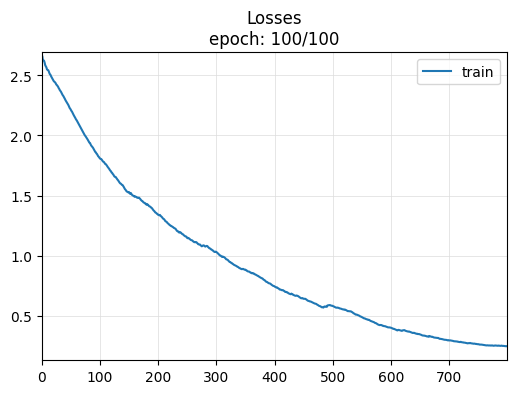

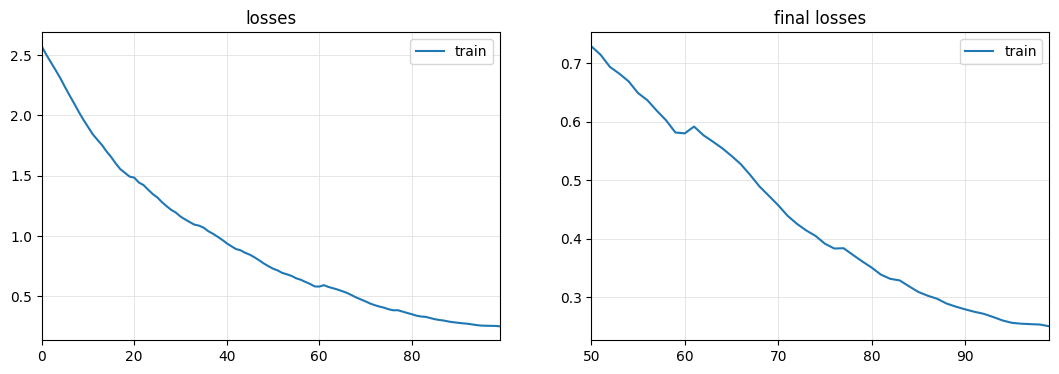

In [13]:
learn = ts_learner(dls, InceptionTime, metrics=accuracy , cbs=ShowGraph())
learn.fit_one_cycle(100)

In [81]:
X_t, y_t, splits = combine_split_data([X_test], [y_test])
probas, targets, preds = learn.get_X_preds(X_t, y_t, with_decoded=True)

In [85]:
it_y_preds = np.argmax(probas, axis=-1)
accuracy = accuracy_score(y_t, it_y_preds)
print(f"InceptionTime Accuracy: {accuracy*100:.4f}%")
# top5_accuracy = compute_top_5_accuracy(y_test, it_y_preds)
# print(f'InceptionTime top 5 Accuracy: {top5_accuracy*100:.4f}%')

InceptionTime Accuracy: 86.0465%
